# Practice Case Social Media Analysis

![Image](https://www.softwareadvice.com/resources/wp-content/uploads/The-Best-Free-Tools-for-Twitter-Sentiment-Analysis-Tile.png)

* 0 untuk tweet yang memiliki sentimen negatif
* 1 untuk tweet yang memiliki sentimen positif

Objektif : `Klasifikasi tweet yang sudah memiliki label sentiment menggunakan beberapa model algoritma.`

## 0. Library

Kumpulan library yang digunakan

In [260]:
#import warnings untuk ignore pesan warning
import warnings
warnings.filterwarnings("ignore")

#Library untuk progress bar
from tqdm import tqdm_notebook as tqdm

#Library untuk load data
import pandas as pd

#Library untuk text-preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import numpy as np

#Library untuk feature extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import train_test_split

#Library untuk model
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB

#Library untuk metrics 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#visualization
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

#import image
from IPython.display import Image
from IPython.core.display import HTML 

In [199]:
df_tweets = pd.read_csv('clean_tweet.csv')

In [200]:
df_tweets.head()

,text,target
0,awww that s a bummer you shoulda got david car...,0
1,is upset that he can t update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0


### Create Column 'score'

Membuat kolom `score` untuk menjelaskan `0 = negatif` dan `1 = positif`. 

In [201]:
df_tweets['score'] = df_tweets['target'].map({0:'negative', 1: 'positive'})

## 1. Preprocessing

### 1.1 Drop NA

Mengecek apakah ada kolom yang tidak berisi tweet dan menghilangkannya dari dataset.

In [202]:
df_tweets.isna().sum()

text      3247
target       0
score        0
dtype: int64

In [203]:
df_tweets = df_tweets.dropna()

Melihat panjang baris dan kolom dari dataset.

In [204]:
df_tweets.shape

(1596753, 3)

### 1.2 Drop duplicates

Mengecek tweet yang berduplikat dan menghapusnya.

In [205]:
df_tweets.drop_duplicates(keep=False,inplace=True)

### 1.3 Stopwords removal

Menghapus kata hubung yang tersedia di dataset.

In [206]:
%%time

stop = stopwords.words('english')
df_tweets['text'] = df_tweets['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

Wall time: 1min


### 1.4 Rare words removal

Menghapus kata yang paling jarang muncul. Dengan asumsi, kata yang memiliki frekuensi 1 merupakan 'bahasa gaul' yang digunakan orang orang dalam tweet.

In [207]:
%%time

rare_word = pd.Series(' '.join(df_tweets['text']).split()).value_counts()[-1000:]
rare_word = list(rare_word.index)

Wall time: 11.3 s


In [208]:
df_clean = df_tweets.copy()

In [209]:
%%time

df_clean['text'] = df_clean['text'].apply(lambda x: " ".join(x for x in x.split() if x not in rare_word))

Wall time: 3min 54s


In [210]:
df_clean.head()

,text,target,score
0,awww bummer shoulda got david carr third day,0,negative
1,upset update facebook texting might cry result...,0,negative
2,dived many times ball managed save rest go bounds,0,negative
3,whole body feels itchy like fire,0,negative
4,behaving mad see,0,negative


### 1.5 Stemming

Menyederhanakan kata-kata tweet yang memiliki imbuhan menjadi kata dasar.

In [211]:
%%time

st = PorterStemmer()
df_clean['text'] = df_clean['text'][:].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

Wall time: 5min 34s


## 2. Data Exploration

Melihat distribusi tweet pada dataset dan hasil dari wordcloud yang digunakan

### 2.1 Distribution Plot

In [212]:
#count sentiment 
sentiment = df_clean.groupby(['score'])['score'].count()
sentiment

#make dataframe that will be created a chart 
chart = pd.DataFrame(sentiment)
chart['tweet_count'] = chart['score']
chart.drop(['score'], axis = 1, inplace = True )
chart = chart.reset_index()

#make a proportion of the number of tweet of each sentiment 
chart['percent'] = chart['tweet_count']/chart['tweet_count'].sum()

Text(0.5,1,'Sentiment Class')

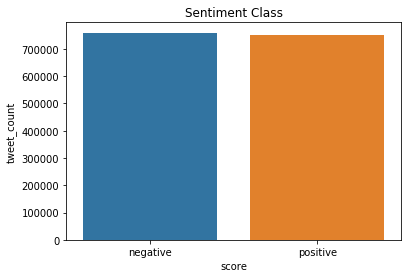

In [213]:
#visualization 
ax = sns.barplot(x= 'score', y='tweet_count', data=chart)
ax.set_title('Sentiment Class')

#### `Komentar BOZ`

### 2.2 Word Cloud

In [214]:
#define happy and not happy 
happy = df_clean.loc[df_clean['score'] == "positive"]
not_happy  = df_clean.loc[df_clean['score'] == "negative"]

In [215]:
#merge all the happy comments into one paragraph
all_description_happy = "".join(happy.text.values)
all_description_not_happy = "".join(not_happy.text.values)

In [216]:
#make a wordcloud 
def create_word_cloud(string):
    cloud = WordCloud(background_color = "white", max_words = 200, stopwords = set(STOPWORDS)).generate(string)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

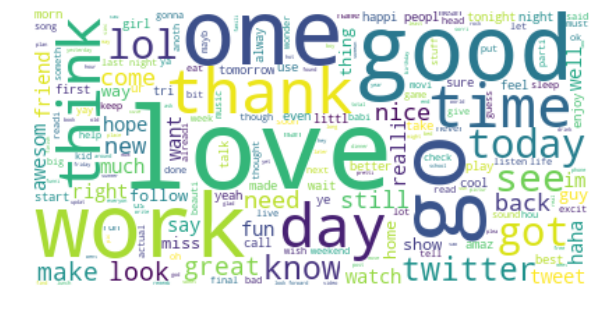

In [217]:
#happy
plt.figure(figsize=(10,10))
create_word_cloud(all_description_happy)

`Teksnya kurang nih`

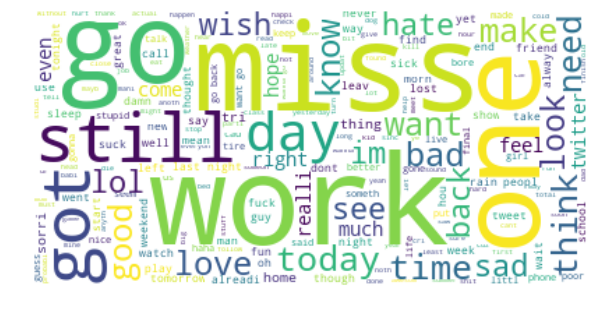

In [218]:
#nothappy
plt.figure(figsize=(10,10))
create_word_cloud(all_description_not_happy)

`Teksnya kurang nih`

## 2. Feature Extraction

Mencoba 4 metode dalam melakukan ekstraksi fitur. Ada 4 metode yang digunakan:

1. Count vectorizer
2. Count vectorizer Bigram
3. TFIDF
4. Hashing vectorizer

In [219]:
count_vectorizer = CountVectorizer()

In [220]:
count_vectorizer_bigram = CountVectorizer(ngram_range=(2,2))

In [221]:
tfidf = TfidfVectorizer()

In [222]:
hashing_vectorizer = HashingVectorizer(alternate_sign=False)

## 3. Modelling

### 3.1 Fit Transform

Memberi variabel model yang diberikan agar lebih mudah digunakan

In [223]:
X = df_clean['text']
y = df_clean['target']

In [224]:
%%time

#countvectorizer
X_vectorizer = count_vectorizer.fit_transform(X)

Wall time: 22.5 s


In [225]:
%%time

#tfidf vectorizer
X_tfidf = tfidf.fit_transform(X)

Wall time: 22.4 s


In [226]:
%%time

#countvectorizer bigram
X_vectorizer_bigram = count_vectorizer_bigram.fit_transform(X)

Wall time: 57.5 s


In [227]:
%%time

#hash vectorizer
X_hash_vect = hashing_vectorizer.fit_transform(X)

Wall time: 14.7 s


### 3.2 Train Test Split

Membagi dataset menjadi train dan test. Dengan porsi 20% pada test dan 80% pada training. Karena percobaan sebelumnya metode `hashing vectorizer` mengalami _overfitting_ pada metodenya. Sehingga akan saya coba terapkan metode `Train, test dan validation` untuk benar benar mengecek apakah terjadi _overfitting_ atau tidak.

In [228]:
#train test split using countvectorizer 
train_X_vectorizer, test_X_vectorizer,
train_y, test_y = train_test_split(X_vectorizer, y,test_size=0.2, random_state=0)

In [229]:
#train test split using tfidfvectorizer 
train_X_tfidf, test_X_tfidf,
train_y, test_y = train_test_split(X_tfidf, y,test_size=0.2, random_state=0)

In [230]:
#train test split using hashingvectorizer 
train_X_hashingvectorizer, test_X_hashingvectorizer,
train_y, test_y = train_test_split(X_hash_vect, y, test_size=0.2, random_state=0)

In [231]:
#train test split using countvectorizer bigram
train_X_vectorizer_bigram, test_X_vectorizer_bigram,
train_y, test_y = train_test_split(X_vectorizer_bigram, y, test_size=0.2, random_state=0)

## 4. Model Machine Learning

a. Logistic regression <br>
Regresi logistic merupakan salah satu analisi multivariate, yang berguna untuk memprediksi dependent variabel berdasarkan variabel independen. <br>

b. Naive Bayes <br>
merupakan salah satu metoda pemelajaran mesin yang memanfaatkan perhitungan probabilitas dan statistik yang dikemukakan oleh ilmuwan Inggris Thomas Bayes, yaitu memprediksi probabilitas di masa depan berdasarkan pengalaman di masa sebelumnya. <br>



### 4.1 Logistic Regression

`text`

In [232]:
%%time

# Countvectorizer 
Lr_vect = LogisticRegression()
Lr_vect.fit(train_X_vectorizer,train_y)
Lr_pred_vect_train = Lr_vect.predict(train_X_vectorizer)
Lr_pred_vect_test = Lr_vect.predict(test_X_vectorizer)

Wall time: 2min 14s


In [233]:
%%time

# CountvectorizerBiGram
Lr_vect = LogisticRegression()
Lr_vect.fit(train_X_vectorizer_bigram,train_y)
Lr_pred_vect_bi_train = Lr_vect.predict(train_X_vectorizer_bigram)
Lr_pred_vect_bi_test = Lr_vect.predict(test_X_vectorizer_bigram)

Wall time: 1min 52s


In [234]:
%%time

# TFIDFVectorizer
Lr_tfidf = LogisticRegression()
Lr_tfidf.fit(train_X_tfidf,train_y)
Lr_pred_tfidf_train = Lr_tfidf.predict(train_X_tfidf)
Lr_pred_tfidf_test = Lr_tfidf.predict(test_X_tfidf)

Wall time: 38.9 s


In [235]:
%%time

# HashingVectorizer
Lr_hv = LogisticRegression()
Lr_hv.fit(train_X_hashingvectorizer,train_y)
Lr_pred_hv_train = Lr_hv.predict(train_X_hashingvectorizer)
Lr_pred_hv_test = Lr_hv.predict(test_X_hashingvectorizer)

Wall time: 1min 4s


### 4.2 Naive Bayes

`text`

In [236]:
%%time

# Countvectorizer
NB_vect = MultinomialNB()
NB_vect.fit(train_X_vectorizer,train_y)
NB_pred_vect_train = NB_vect.predict(train_X_vectorizer)
NB_pred_vect_test = NB_vect.predict(test_X_vectorizer)

Wall time: 1.06 s


In [237]:
%%time

# CountvectorizerBiGram
NB_vect = MultinomialNB()
NB_vect.fit(train_X_vectorizer_bigram,train_y)
NB_pred_vect_bi_train = NB_vect.predict(train_X_vectorizer_bigram)
NB_pred_vect_bi_test = NB_vect.predict(test_X_vectorizer_bigram)

Wall time: 1.53 s


In [238]:
%%time

# TFIDFVectorizer
NB_tfidf = MultinomialNB()
NB_tfidf.fit(train_X_tfidf,train_y)
NB_pred_tfidf_train = NB_tfidf.predict(train_X_tfidf)
NB_pred_tfidf_test = NB_tfidf.predict(test_X_tfidf)

Wall time: 698 ms


In [239]:
%%time

# HashingVectorizer
NB_hv = MultinomialNB()
NB_hv.fit(train_X_hashingvectorizer,train_y)
NB_pred_hv_train = NB_hv.predict(train_X_hashingvectorizer)
NB_pred_hv_test = NB_hv.predict(test_X_hashingvectorizer)

Wall time: 826 ms


## 5. Model Evaluation

Evaluasi yang digunakan untuk menguji model yang digunakan.

* Precision = Tingkat ketepatan antara informasi yang diminta oleh pengguna dengan jawaban yang diberikan oleh sistem. <br>
* Recall = Tingkat keberhasilan sistem dalam menemukan kembali sebuah informasi. <br>
* F_measure = Perhitungan evaluasi dalam informasi temu kembali yang mengkombinasikan recall dan precission. <br>

### 5.1 Logistic regression

In [240]:
# using count vectorizer

Lr_recall_vec_train = recall_score(train_y, Lr_pred_vect_train, average="micro")
Lr_recall_vec_test = recall_score(test_y, Lr_pred_vect_test,average="micro") 

Lr_precision_vec_train = precision_score(train_y, Lr_pred_vect_train,average="micro")
Lr_precision_vec_test = precision_score(test_y, Lr_pred_vect_test,average="micro")

Lr_f1_score_vec_train = f1_score(train_y, Lr_pred_vect_train,average="micro")
Lr_f1_score_vec_test = f1_score(test_y,Lr_pred_vect_test,average="micro")

In [241]:
# using count bigram vectorizer

Lr_recall_bivec_train = recall_score(train_y, Lr_pred_vect_bi_train, average="micro")
Lr_recall_bivec_test = recall_score(test_y, Lr_pred_vect_bi_test,average="micro") 

Lr_precision_bivec_train = precision_score(train_y, Lr_pred_vect_bi_train,average="micro")
Lr_precision_bivec_test = precision_score(test_y, Lr_pred_vect_bi_test,average="micro")

Lr_f1_score_bivec_train = f1_score(train_y, Lr_pred_vect_bi_train,average="micro")
Lr_f1_score_bivec_test = f1_score(test_y,Lr_pred_vect_bi_test,average="micro")

In [242]:
# using TFIDF vectorizer

Lr_recall_tfidf_train = recall_score(train_y, Lr_pred_tfidf_train, average="micro")
Lr_recall_tfidf_test = recall_score(test_y, Lr_pred_tfidf_test,average="micro") 

Lr_precision_tfidf_train = precision_score(train_y, Lr_pred_tfidf_train,average="micro")
Lr_precision_tfidf_test = precision_score(test_y, Lr_pred_tfidf_test,average="micro")

Lr_f1_score_tfidf_train = f1_score(train_y, Lr_pred_tfidf_train,average="micro")
Lr_f1_score_tfidf_test = f1_score(test_y,Lr_pred_tfidf_test,average="micro")

In [243]:
# using HashVectorizer vectorizer

Lr_recall_hv_train = recall_score(train_y, Lr_pred_hv_train, average="micro")
Lr_recall_hv_test = recall_score(test_y, Lr_pred_hv_test,average="micro") 

Lr_precision_hv_train = precision_score(train_y, Lr_pred_hv_train,average="micro")
Lr_precision_hv_test = precision_score(test_y, Lr_pred_hv_test,average="micro")

Lr_f1_score_hv_train = f1_score(train_y, Lr_pred_hv_train,average="micro")
Lr_f1_score_hv_test = f1_score(test_y,Lr_pred_hv_test,average="micro")

### 5.2 Naive Bayes

In [244]:
# using count vectorizer

NB_recall_vec_train = recall_score(train_y, NB_pred_vect_train, average="micro")
NB_recall_vec_test = recall_score(test_y, NB_pred_vect_test,average="micro") 

NB_precision_vec_train = precision_score(train_y, NB_pred_vect_train,average="micro")
NB_precision_vec_test = precision_score(test_y, NB_pred_vect_test,average="micro")

NB_f1_score_vec_train = f1_score(train_y, NB_pred_vect_train,average="micro")
NB_f1_score_vec_test = f1_score(test_y,NB_pred_vect_test,average="micro")

In [245]:
# using count bigram vectorizer

NB_recall_bivec_train = recall_score(train_y, NB_pred_vect_bi_train, average="micro")
NB_recall_bivec_test = recall_score(test_y, NB_pred_vect_bi_test,average="micro") 

NB_precision_bivec_train = precision_score(train_y, NB_pred_vect_bi_train,average="micro")
NB_precision_bivec_test = precision_score(test_y, NB_pred_vect_bi_test,average="micro")

NB_f1_score_bivec_train = f1_score(train_y, NB_pred_vect_bi_train,average="micro")
NB_f1_score_bivec_test = f1_score(test_y,NB_pred_vect_bi_test,average="micro")

In [246]:
# using tf-idf

NB_recall_tfidf_train = recall_score(train_y, NB_pred_tfidf_train, average="micro")
NB_recall_tfidf_test = recall_score(test_y, NB_pred_tfidf_test,average="micro") 

NB_precision_tfidf_train = precision_score(train_y, NB_pred_tfidf_train,average="micro")
NB_precision_tfidf_test = precision_score(test_y, NB_pred_tfidf_test,average="micro")

NB_f1_score_tfidf_train = f1_score(train_y, NB_pred_tfidf_train,average="micro")
NB_f1_score_tfidf_test = f1_score(test_y,NB_pred_tfidf_test,average="micro")

In [247]:
#using HashVectorizer

NB_recall_hv_train = recall_score(train_y, NB_pred_hv_train, average="micro")
NB_recall_hv_test = recall_score(test_y, NB_pred_hv_test,average="micro")

NB_precision_hv_train = precision_score(train_y, NB_pred_hv_train,average="micro")
NB_precision_hv_test = precision_score(test_y, NB_pred_hv_test,average="micro")

NB_f1_score_hv_train = f1_score(train_y, NB_pred_hv_train,average="micro")
NB_f1_score_hv_test = f1_score(test_y,NB_pred_hv_test,average="micro")

## 6. Conclusion

In [255]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [261]:
print(color.GREEN + color.BOLD + 'Model: Logistic Regression' + color.END)
print()
print(color.BOLD + 'Countvectorizer' + color.END)
print('Recall train & test     : %.2f%%' % (Lr_recall_vec_train * 100), '&', '%.2f%%' % (Lr_recall_vec_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_vec_train * 100), '&', '%.2f%%' % (Lr_precision_vec_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_vec_train * 100), '&', '%.2f%%' % (Lr_f1_score_vec_test * 100))
print()
print(color.BOLD + "CountvectorizerBiGram"+ color.END)
print('Recall train & test     : %.2f%%' % (Lr_recall_bivec_train * 100), '&', '%.2f%%' % (Lr_recall_bivec_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_bivec_train * 100), '&', '%.2f%%' % (Lr_precision_bivec_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_bivec_train * 100), '&', '%.2f%%' % (Lr_f1_score_bivec_test * 100))
print()
print(color.BOLD + "TF-IDF" + color.END)
print('Recall train & test     : %.2f%%' % (Lr_recall_tfidf_train * 100), '&', '%.2f%%' % (Lr_recall_tfidf_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_tfidf_train * 100), '&', '%.2f%%' % (Lr_precision_tfidf_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_tfidf_train * 100), '&', '%.2f%%' % (Lr_f1_score_tfidf_test * 100))
print()
print(color.BOLD + "Hash Vectorizer" + color.END)
print('Recall train & test     : %.2f%%' % (Lr_recall_hv_train * 100), '&', '%.2f%%' % (Lr_recall_hv_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_hv_train * 100), '&', '%.2f%%' % (Lr_precision_hv_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_hv_train * 100), '&', '%.2f%%' % (Lr_f1_score_hv_test * 100))

print()
print()
print(color.GREEN + color.BOLD + 'Model: Naive Bayes' + color.END )
print()
print(color.BOLD + 'Countvectorizer' + color.END)
print('Recall train & test     : %.2f%%' % (NB_recall_vec_train * 100), '&', '%.2f%%' % (NB_recall_vec_test * 100))
print('Precision train & test  : %.2f%%' % (NB_precision_vec_train * 100), '&', '%.2f%%' % (NB_precision_vec_test * 100))
print('F1 Score train & test   : %.2f%%' % (NB_f1_score_vec_train * 100), '&', '%.2f%%' % (NB_f1_score_vec_test * 100))
print()
print(color.BOLD + "CountvectorizerBiGram"+ color.END)
print('Recall train & test     : %.2f%%' % (NB_recall_bivec_train * 100), '&', '%.2f%%' % (NB_recall_bivec_test * 100))
print('Precision train & test  : %.2f%%' % (NB_precision_bivec_train * 100), '&', '%.2f%%' % (NB_precision_bivec_test * 100))
print('F1 Score train & test   : %.2f%%' % (NB_f1_score_bivec_train * 100), '&', '%.2f%%' % (NB_f1_score_bivec_test * 100))
print()
print(color.BOLD + "TF-IDF" + color.END)
print('Recall train & test     : %.2f%%' % (NB_recall_tfidf_train * 100), '&', '%.2f%%' % (NB_recall_tfidf_test * 100))
print('Precision train & test  : %.2f%%' % (NB_precision_tfidf_train * 100), '&', '%.2f%%' % (NB_precision_tfidf_test * 100))
print('F1 Score train & test   : %.2f%%' % (NB_f1_score_tfidf_train * 100), '&', '%.2f%%' % (NB_f1_score_tfidf_test * 100))
print()
print(color.BOLD + "Hash Vectorizer" + color.END)
print('Recall train & test     : %.2f%%' % (NB_recall_hv_train * 100), '&', '%.2f%%' % (NB_recall_hv_test * 100))
print('Precision train & test  : %.2f%%' % (NB_precision_hv_train * 100), '&', '%.2f%%' % (NB_precision_hv_test * 100))
print('F1 Score train & test   : %.2f%%' % (NB_f1_score_hv_train * 100), '&', '%.2f%%' % (NB_f1_score_hv_test * 100))

Model: Logistic Regression

Countvectorizer
Recall train & test     : 79.70% & 76.69%
Precision train & test  : 79.70% & 76.69%
F1 Score train & test   : 79.70% & 76.69%

CountvectorizerBiGram
Recall train & test     : 94.69% & 72.44%
Precision train & test  : 94.69% & 72.44%
F1 Score train & test   : 94.69% & 72.44%

TF-IDF
Recall train & test     : 78.92% & 76.87%
Precision train & test  : 78.92% & 76.87%
F1 Score train & test   : 78.92% & 76.87%

Hash Vectorizer
Recall train & test     : 78.06% & 76.81%
Precision train & test  : 78.06% & 76.81%
F1 Score train & test   : 78.06% & 76.81%


Model: Naive Bayes

Countvectorizer
Recall train & test     : 78.40% & 75.63%
Precision train & test  : 78.40% & 75.63%
F1 Score train & test   : 78.40% & 75.63%

CountvectorizerBiGram
Recall train & test     : 92.32% & 72.93%
Precision train & test  : 92.32% & 72.93%
F1 Score train & test   : 92.32% & 72.93%

TF-IDF
Recall train & test     : 78.31% & 74.92%
Precision train & test  : 78.31% & 74.92%

`TOLONG DIISI TEXT`